# Group Slowness Exploration

In [56]:
%reload_ext autoreload
%autoreload 2

In [57]:
import torch
import jkbc.model.factory as factory
import jkbc.utils.bonito.tune as bonito

In [58]:
device = torch.device("cuda")
window_size = 4096
groups_for_g = 2

In [59]:
# Config for no groups
config_nog = {'b1_dilation': 1,
 'b1_filters': 256,
 'b1_kernel': 33,
 'b1_repeat': 5,
 'b1_groups': 1,
 'b1_shuffle': False,
 'b2_dilation': 1,
 'b2_filters': 256,
 'b2_kernel': 39,
 'b2_repeat': 5,
 'b2_groups': 1,
 'b2_shuffle': False,
 'b3_dilation': 1,
 'b3_filters': 512,
 'b3_kernel': 51,
 'b3_repeat': 5,
 'b3_groups': 1,
 'b3_shuffle': False,
 'b4_dilation': 1,
 'b4_filters': 512,
 'b4_kernel': 63,
 'b4_repeat': 5,
 'b4_groups': 1,
 'b4_shuffle': False,
 'b5_dilation': 1,
 'b5_filters': 512,
 'b5_kernel': 75,
 'b5_repeat': 5,
 'b5_groups': 1,
 'b5_shuffle': False,
 'b_blocks': 5,
 'c1_filters': 256,
 'c1_kernel': 33,
 'c1_stride': 3,
 'c2_filters': 512,
 'c2_kernel': 87,
 'c3_filters': 1024,
 'c3_kernel': 1,
 'dropout': 0.0,
 'scale_output_to_size': None}

In [61]:
# Config for groups
group_keys = ['b1_groups', 'b2_groups', 'b3_groups', 'b4_groups', 'b5_groups']
config_g = config_nog.copy()
for key in group_keys:
    config_g[key] = groups_for_g

In [62]:
# no groups
bon_conf_nog = bonito.get_bonito_config(config_nog, double_kernel_sizes=False)
model_nog, _ = factory.bonito(window_size, device, bon_conf_nog)

In [63]:
# groups
bon_conf_g = bonito.get_bonito_config(config_g, double_kernel_sizes=False)
model_g, _ = factory.bonito(window_size, device, bon_conf_g);

In [64]:
def signal_to_input_tensor(signal, device, dtype=torch.float16):
    if type(signal) == torch.Tensor:
        x = signal.to(device=device, dtype=dtype)
    else:
        x = torch.tensor(signal, dtype=dtype, device=device)
    
    return x.view(x.shape[0],1,x.shape[1])

def time_model_prediction(model, device, count=100, dtype=torch.float16):
    ## count increased to 100 from 20 to increase accuracy.
    ## we device by 5 to make the measure backwards compatible 
    import timeit
    signal = torch.ones(16, 4096, device=device)
    input = signal_to_input_tensor(signal, device, dtype)
    fn = lambda: model(input).detach().cpu()
    return timeit.timeit(fn, number=count)/5

# Experiments

In [65]:
count = 100

## dtype = half (float16)
This is the current default in our setup

In [66]:
model_nog.half();

In [67]:
time_model_prediction(model_nog, device, count=count, dtype=torch.float16)

0.6427324988064356

Time : 0.6440459997975267

In [ ]:
model_g.half();

In [ ]:
time_model_prediction(model_g, device, count=count, dtype=torch.float16)

Time: 3.0932368531939574

## dtype = float (float32)

In [23]:
model_nog.float();
time_model_prediction(model_nog, device, count=count, dtype=torch.float32)

0.954584093997255

Time = 0.954584093997255

In [24]:
model_g.float();
time_model_prediction(model_g, device, count=count, dtype=torch.float32)

0.8280312177957967

Time = 0.8280312177957967

## dtype = double

In [26]:
model_nog.double();
time_model_prediction(model_nog, device, count=count, dtype=torch.double)

18.127830775198525

In [28]:
model_g.double();
time_model_prediction(model_g, device, count=count, dtype=torch.double)

12.400196660601068

# Stats

In [29]:
import matplotlib.pyplot as plt

[Text(0, 0.5, 'prediction time (sec)'),
 Text(0.5, 0, 'data types'),
 Text(0.5, 1.0, 'The effect of Data types on Conv Groups')]

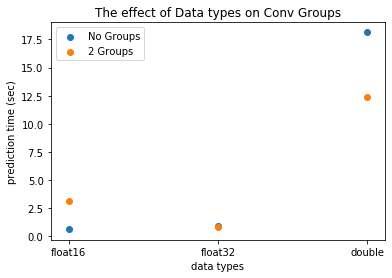

In [52]:
fig, ax = plt.subplots()

x = [0, 1, 2]

x_labels = ['float16', 'float32', 'double']
plt.xticks(x, x_labels)

y_nog = [0.644, 0.954, 18.127]
y_g = [3.093, 0.828, 12.400]

sct_nog = plt.scatter(x, y_nog, label='nog')
sct_g = plt.scatter(x, y_g, label='g')
plt.legend([sct_nog, sct_g], ['No Groups', "2 Groups"])

ax.set(xlabel="data types", ylabel="prediction time (sec)", title="The effect of Data types on Conv Groups")